<a href="https://colab.research.google.com/github/TaniaZharova2205/HSE/blob/main/DZ7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


In [ ]:
pip install -q h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import math
import pandas as pd
import numpy as np
import os
import h2o
from h2o.automl import H2OAutoML
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from scipy.stats import skew
import lightgbm as lgb
import xgboost as xgb

In [ ]:
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [ ]:
# Функция для уменьшения потребления памяти
def reduce_mem_usage(df):
    NAlist = []
    for col in tqdm(df.columns, desc="Reducing memory usage"):
        if df[col].dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()

            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col] = df[col].fillna(col_min - 1)

            rounded = np.rint(df[col])
            if np.allclose(df[col], rounded, atol=1e-3):
                col_min, col_max = rounded.min(), rounded.max()
                if col_min >= 0:
                    if col_max < 255:
                        df[col] = rounded.astype(np.uint8)
                    elif col_max < 65535:
                        df[col] = rounded.astype(np.uint16)
                    elif col_max < 4294967295:
                        df[col] = rounded.astype(np.uint32)
                    else:
                        df[col] = rounded.astype(np.uint64)
                else:
                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        df[col] = rounded.astype(np.int8)
                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        df[col] = rounded.astype(np.int16)
                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        df[col] = rounded.astype(np.int32)
                    else:
                        df[col] = rounded.astype(np.int64)
            else:
                df[col] = df[col].astype(np.float32)
    return df, NAlist

In [ ]:
INPUT_DIR = '.'
train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity

df_train, df_train_NAlist = reduce_mem_usage(df_train)
df_test, df_test_NAlist = reduce_mem_usage(df_test)

Reducing memory usage: 100%|██████████| 433/433 [00:02<00:00, 197.57it/s]


# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

#### 1. Размер данных и количество дубликатов

In [ ]:
print("Размер таблицы Train:", df_train.shape)
print("\nРазмер таблицы Test:", df_test.shape)
print("\nКоличество дубликатов в df_train:", df_train.duplicated().sum())
print("\nКоличество дубликатов в df_test:", df_test.duplicated().sum())

Размер таблицы Train: (417559, 434)

Размер таблицы Test: (172981, 433)

Количество дубликатов в df_train: 0

Количество дубликатов в df_test: 0


In [ ]:
print('Отсутствующая колонка в df_test:', set(df_train.columns) - set(df_test.columns))

Отсутствующая колонка в df_test: {'isFraud'}


> Дубликатов нет, поэтому удалять нечего. Отсутствующая колонка в df_test - норма, так как для теста как раз и надо сделать предсказания по этой колонке.

#### 2. Анализ пропусков в Датасете

In [ ]:
missing_values_train = df_train.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0].sort_values(ascending=False)
print("Количество колонок с пропущенными значениями в df_train:", missing_values_train.shape[0])

Количество колонок с пропущенными значениями в df_train: 30


In [ ]:
missing_values_test = df_test.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0].sort_values(ascending=False)
print("Количество колонок с пропущенными значениями в df_test:", missing_values_test.shape[0])

Количество колонок с пропущенными значениями в df_test: 30


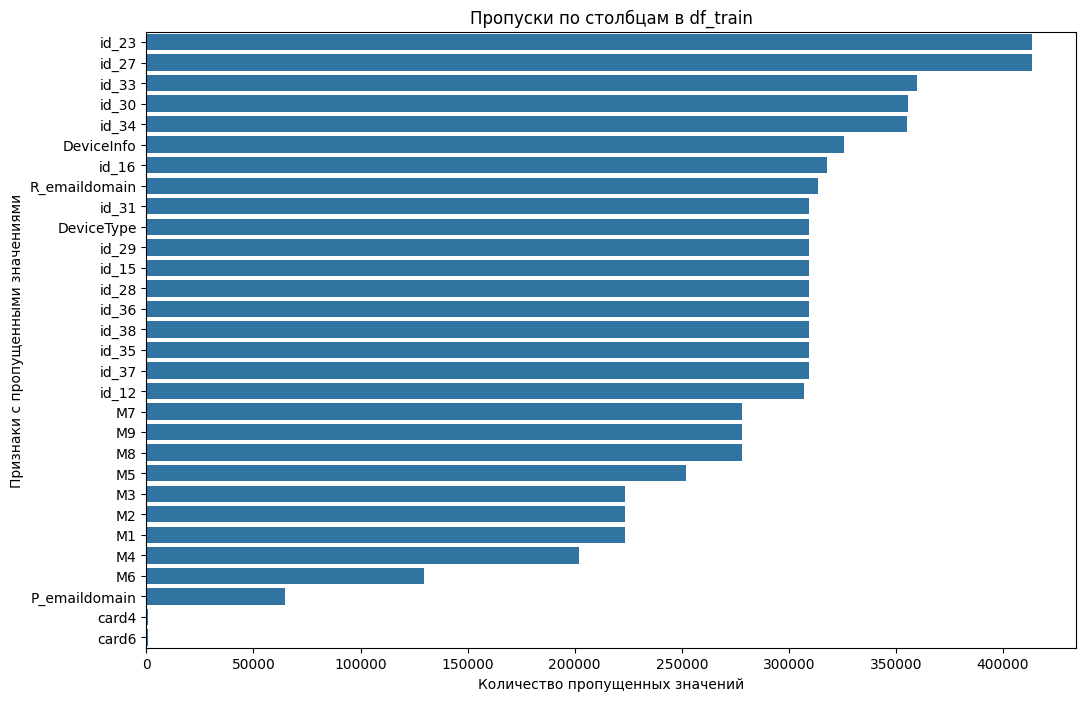

In [ ]:
# Более наглядное распределение пропущенных значений в обучающей выборке
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values_train.values, y=missing_values_train.index, orient='h')
plt.xlabel("Количество пропущенных значений")
plt.ylabel("Признаки с пропущенными значениями")
plt.title("Пропуски по столбцам в df_train")
plt.show()

In [ ]:
for i in missing_values_train.index.to_list():
    print(f"{i} dtype: ", df_train[i].dtype)

id_23 dtype:  object
id_27 dtype:  object
id_33 dtype:  object
id_30 dtype:  object
id_34 dtype:  object
DeviceInfo dtype:  object
id_16 dtype:  object
R_emaildomain dtype:  object
id_31 dtype:  object
DeviceType dtype:  object
id_29 dtype:  object
id_15 dtype:  object
id_28 dtype:  object
id_36 dtype:  object
id_38 dtype:  object
id_35 dtype:  object
id_37 dtype:  object
id_12 dtype:  object
M7 dtype:  object
M9 dtype:  object
M8 dtype:  object
M5 dtype:  object
M3 dtype:  object
M2 dtype:  object
M1 dtype:  object
M4 dtype:  object
M6 dtype:  object
P_emaildomain dtype:  object
card4 dtype:  object
card6 dtype:  object


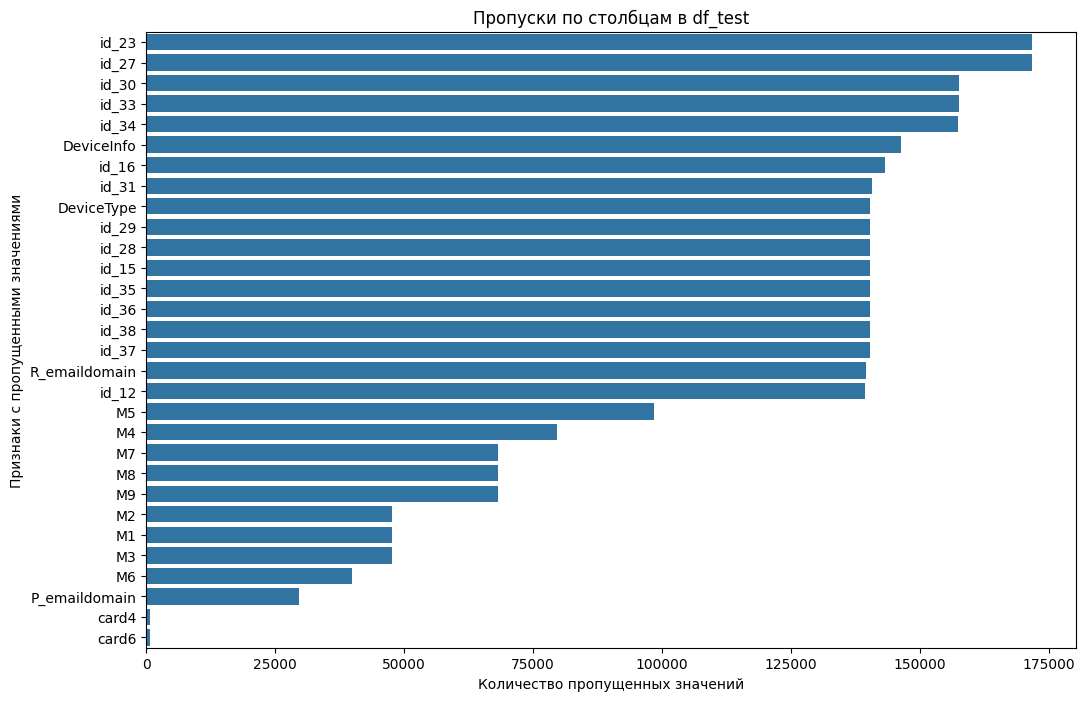

In [ ]:
# Более наглядное распределение пропущенных значений в тестовой выборке
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values_test.values, y=missing_values_test.index, orient='h')
plt.xlabel("Количество пропущенных значений")
plt.ylabel("Признаки с пропущенными значениями")
plt.title("Пропуски по столбцам в df_test")
plt.show()

> Очень много пропусков - в 30 колонках и в большинстве из них пропусков переваливает за 10000. С пропусками последует поступить так: либо исключения таких признаков в целом, либо аккуратного заполнения/кодирования пропусков в формате NaN = «нет данных». Все пропуски расположены в категориальных признаках, поэтому с этой проблемой разобраться довольно просто

#### 4. Анализ целевой переменной

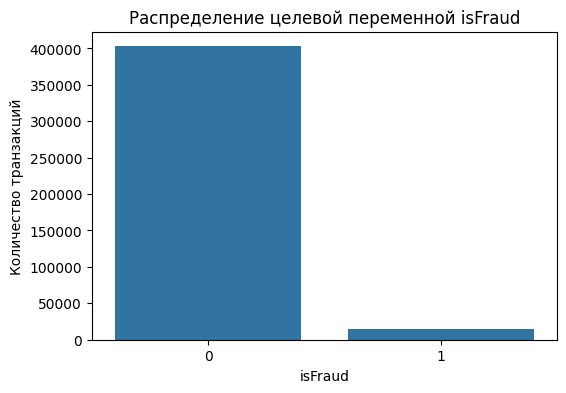

Доля нормальных транзакций: 96.47%
Доля мошеннических транзакций: 3.53%


In [ ]:
plt.figure(figsize=(6,4))
fraud_counts = df_train['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.xlabel("isFraud")
plt.ylabel("Количество транзакций")
plt.title("Распределение целевой переменной isFraud")
plt.show()

total = df_train.shape[0]
print("Доля нормальных транзакций: {:.2f}%".format(fraud_counts.get(0,0)/total*100))
print("Доля мошеннических транзакций: {:.2f}%".format(fraud_counts.get(1,0)/total*100))

> Целевая переменная существенно несбалансирована. C таким дисбалансом понадобится применить специальные приёмы при обучении моделей (коррекция весов классов, oversampling, undersampling и т.д.) для корректной оценки качества и повышения точности модели на редком классе.

#### 5. Попарная зависимость числовых признаков

In [ ]:
types = [np.uint32, np.uint8, np.float32, np.uint16, np.int16, np.int8]
numeric_cols = df_train.select_dtypes(include=types).columns.tolist()

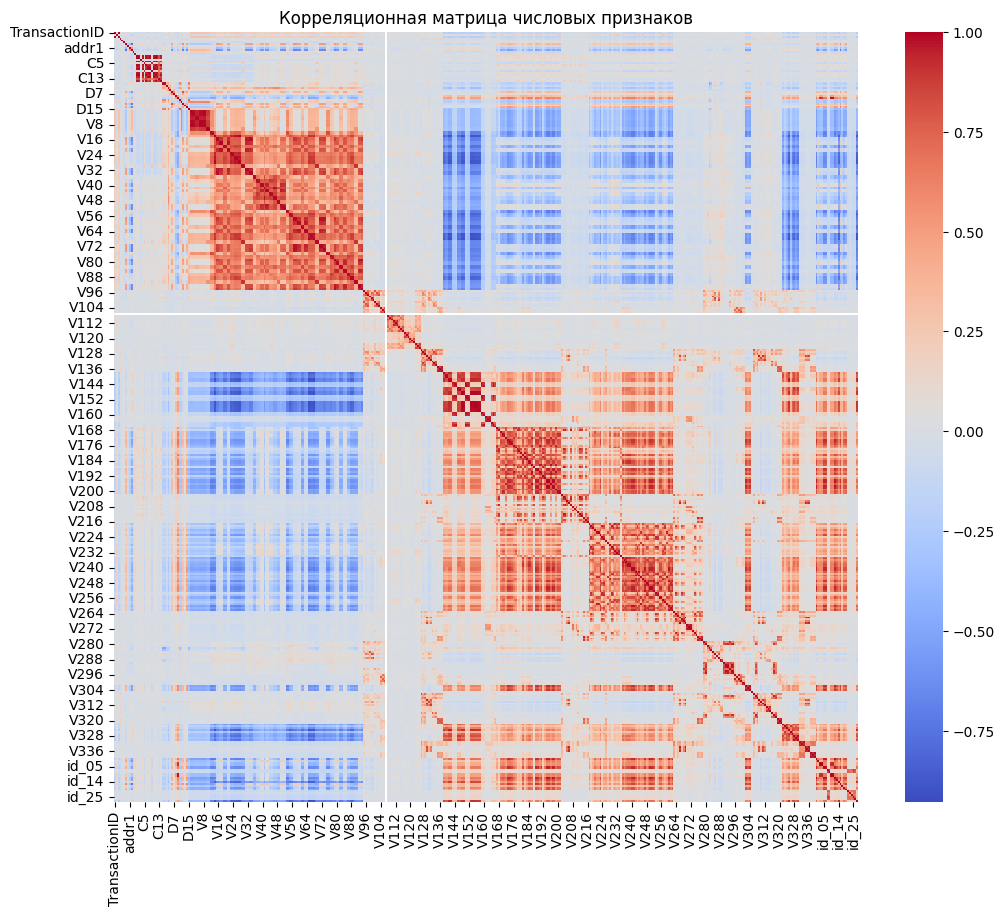

In [ ]:
plt.figure(figsize=(12,10))
corr = df_train[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Корреляционная матрица числовых признаков")
plt.show()

> В данных наблюдаются группы признаков с высокой взаимной корреляцией (особенно среди V-признаков и некоторых C-, D-признаков), что говорит о возможной избыточности информации, что может привести к мультиколлинеарности и усложнить обучение модели.

> При обучении необходимо будет либо отбирать наиболее важные признаки, либо использовать регуляризацию/методы снижения размерности (например, PCA).


#### 6. Анализ категориальных признаков

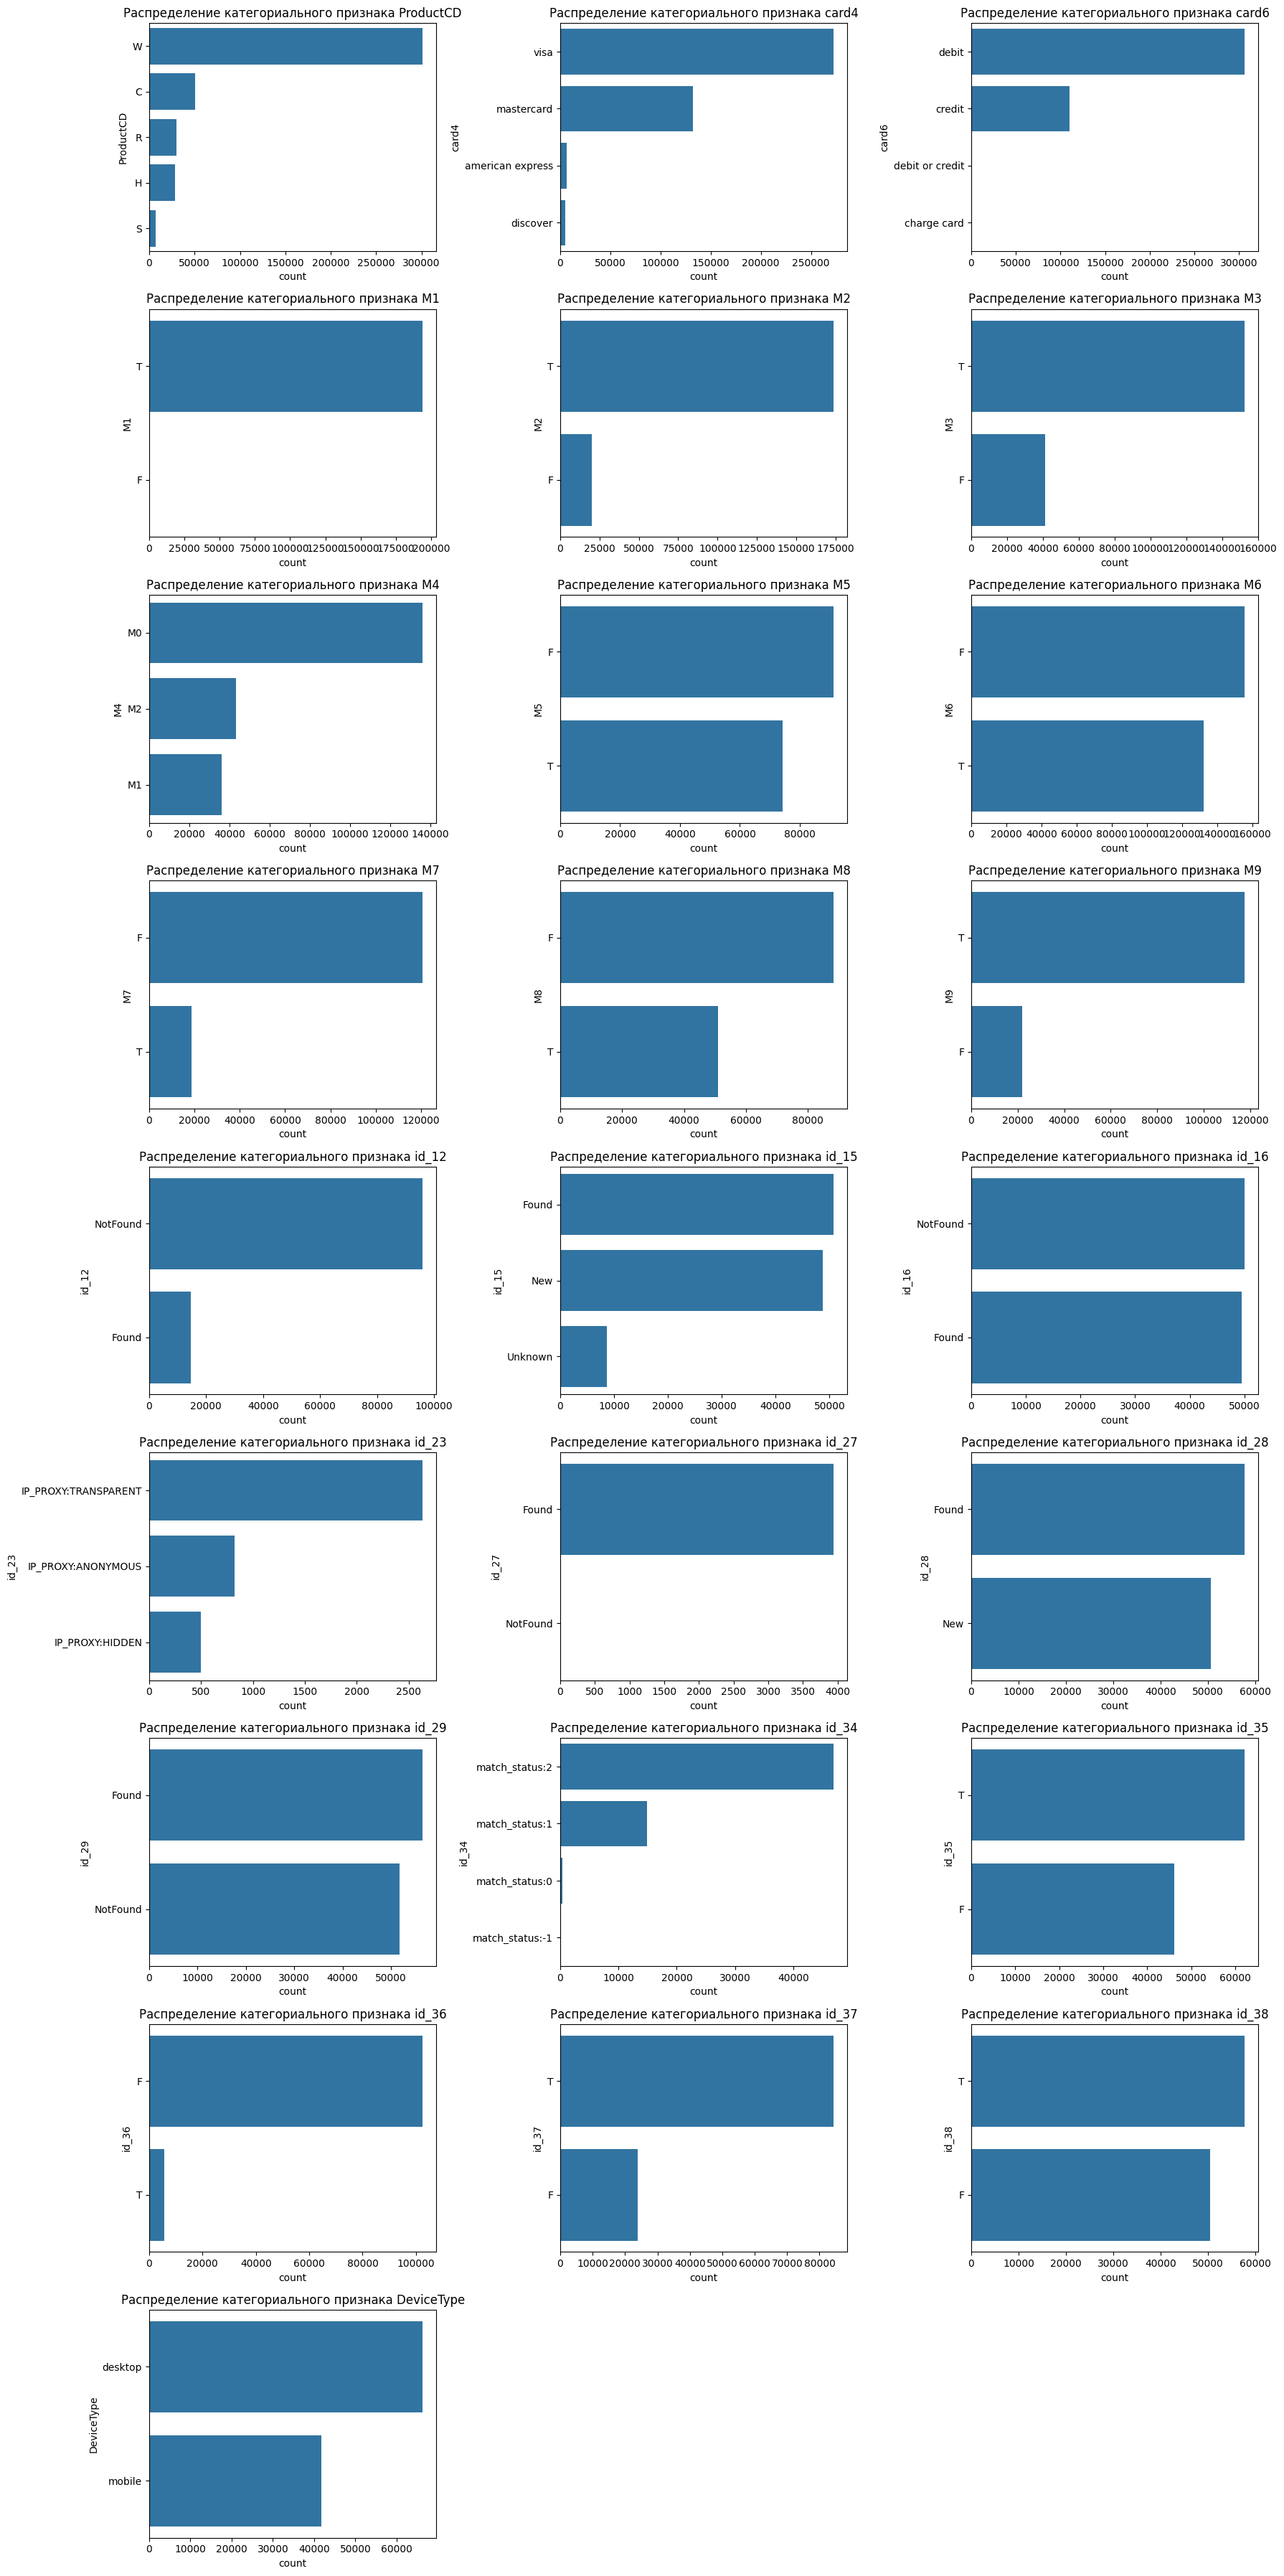

In [ ]:
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
df_categorical = df_train.select_dtypes(include=['object'])
categorical_cols_20 = [col for col in df_categorical if df_categorical[col].nunique() < 20]
num_cols = 3
num_rows = (len(categorical_cols_20) // num_cols) + (1 if len(categorical_cols_20) % num_cols != 0 else 0)

# Создаем сетку графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
axes = axes.flatten()  # Преобразуем axes в одномерный массив для удобства

# Построение графиков
for i, col in enumerate(categorical_cols_20):
    sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Распределение категориального признака {col}')

# Скрываем пустые графики, если количество графиков не кратно 3
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

> Необходимо объединить редкие категории и выделить пропуски как отдельную группу, а затем применить соответствующее кодирование (One-Hot или Target Encoding) для повышения информативности данных.

#### 7. Обработка данных по итогу исследования

In [ ]:
### 1. Удаление признаков с большим количеством пропусков ###
missing_threshold = 0.7 # Удаляем признаки с 70%+ пропусками
missing_rate = df_train.isnull().mean()
cols_to_drop = missing_rate[missing_rate > missing_threshold].index.tolist()
df_train = df_train.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=[col for col in cols_to_drop if col in df_test.columns])
print("Удаленные признаки:", cols_to_drop)

Удаленные признаки: ['R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [ ]:
### 2. Обработка пропусков для признаков, у которых менее 70% пропусков ###
cat_cols = df_train.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_train[col] = df_train[col].fillna('Missing')
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna('Missing')

In [ ]:
# Проверка
missing_values_train = df_train.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0].sort_values(ascending=False)
print("Количество колонок с пропущенными значениями в df_train:", missing_values_train.shape[0])

Количество колонок с пропущенными значениями в df_train: 0


In [ ]:
### 3. Удаление высококоррелируемых признаков (в т.ч. для экономии ресурсов) ###
corr_threshold = 0.9
numeric_df = df_train.drop(columns=['isFraud'], errors='ignore').select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print("Удаляем следующие признаки из-за высокой корреляции:")
print(to_drop)
df_train = df_train.drop(columns=to_drop, errors='ignore')
df_test = df_test.drop(columns=to_drop, errors='ignore')

Удаляем следующие признаки из-за высокой корреляции:
['TransactionDT', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'D2', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V13', 'V16', 'V17', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V38', 'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V49', 'V50', 'V51', 'V52', 'V54', 'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V78', 'V81', 'V83', 'V84', 'V85', 'V87', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V113', 'V137', 'V140', 'V141', 'V142', 'V144', 'V145', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V162', 'V163', 'V165', 'V171', 'V174', 'V175', 'V176', 'V178', 'V179', 'V182', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V19

In [ ]:
### 4. Обработка выбросов (числовые признаки: 5%-95% квантиль) ###
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if 'isFraud' in num_cols:
    num_cols.remove('isFraud')
for col in num_cols:
    lb = df_train[col].quantile(0.05)
    ub = df_train[col].quantile(0.95)
    df_train[col] = df_train[col].clip(lb, ub)
    if col in df_test.columns:
        lb_test = df_test[col].quantile(0.05)
        ub_test = df_test[col].quantile(0.95)
        df_test[col] = df_test[col].clip(lb_test, ub_test)

In [ ]:
### 5. Логарифмическое преобразование для сильно скошенных признаков ###
for col in num_cols:
    if df_train[col].min() >= 0 and skew(df_train[col]) > 1:
        df_train[col] = np.log1p(df_train[col])
        if col in df_test.columns:
            df_test[col] = np.log1p(df_test[col])

In [ ]:
### 6. Замена бесконечностей и заполнение оставшихся NaN ###
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_test = df_test.replace([np.inf, -np.inf], np.nan)
for col in df_train.select_dtypes(include=[np.number]).columns:
    median_val = df_train[col].median()
    df_train[col] = df_train[col].fillna(median_val)
    if col in df_test.columns:
        df_test[col] = df_test[col].fillna(median_val)

In [ ]:
### 7. Кодирование категориальных признаков ###
low_card = [col for col in cat_cols if df_train[col].nunique() < 20]
high_card = [col for col in cat_cols if df_train[col].nunique() >= 20]

df_train = pd.get_dummies(df_train, columns=low_card, drop_first=True)
df_test = pd.get_dummies(df_test, columns=low_card, drop_first=True)

common_cols = df_train.columns.intersection(df_test.columns)
if 'isFraud' in df_train.columns:
    df_train = df_train[list(common_cols) + ['isFraud']]
else:
    df_train = df_train[common_cols]
df_test = df_test[common_cols]

from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in high_card:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    if col in df_test.columns:
        df_test[col] = df_test[col].map(lambda x: x if x in le.classes_ else 'Missing')
        if 'Missing' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'Missing')
        df_test[col] = le.transform(df_test[col])
    le_dict[col] = le

In [ ]:
### 8. Масштабирование числовых признаков ###
scaler = StandardScaler()
final_num_cols = [col for col in df_train.select_dtypes(include=[np.number]).columns if col != 'isFraud']
df_train[final_num_cols] = scaler.fit_transform(df_train[final_num_cols])
df_test[final_num_cols] = scaler.transform(df_test[final_num_cols])

In [ ]:
### Итоговый размер датасетов ###
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (417559, 217)
Test shape: (172981, 216)


**Выводы по пункту:**

1.	Анализ данных:
Обучающий набор содержал в себе большое количество признаков, среди которых многие имеют значительный процент (вплоть до 90%+) пропусков, особенно в идентификационных и категориальных столбцах. Целевая переменная сильно несбалансирована, а числовые признаки демонстрировали выбросы и высокую скошенность, что подтвердило необходимость дополнительных преобразований.

2.	Обработка данных:
- Были удалены признаки с чрезмерными пропусками, а для оставшихся категориальных столбцов пропуски заменены на «Missing».
- Числовые признаки были обработаны посредством обрезки выбросов (5%-95% квантиль) и автоматического логарифмирования для сильно скошенных распределений, затем подвергнуты масштабированию.
- Категориальные признаки закодированы: признаки с низкой кардинальностью – с помощью one-hot encoding, а с высокой – через Label Encoding.

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

#### 1. Разбивка данных и настройка кросс-валидации

In [ ]:
X = df_train.drop(columns=['isFraud'])
y = df_train['isFraud']
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#### 2. Модели и их оценка (CV AUC)

> CatBoost не используем, так как отжирает много ресурсов и сессия валится

> GridSearch для всех моделей идет довольно долго, однако для первых двух моделей удалось определить лучшие метрики:

```
[{'Model': 'LightGBM',
  'Tuned_CV_AUC': 0.9526090579782958,
  'Best_Params': {'learning_rate': 0.1,
   'n_estimators': 200,
   'num_leaves': 63}},
 {'Model': 'XGBoost',
  'Tuned_CV_AUC': 0.9523714772564779,
  'Best_Params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}}]
```

In [ ]:
import time
models_base = {
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, verbose=-1, num_leaves=63),
    'XGBoost': xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=7, eval_metric='auc', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, C=0.1, penalty='l2'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
for name, model in models_base.items():
    print("Обучение модели: ", name)
    start_time = time.time()
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=1)
    end_time = time.time() - start_time
    print("Время обучения модели: ", end_time)
    results.append({'Model': name, 'Baseline_CV_AUC': np.mean(scores)})
results_df = pd.DataFrame(results)

Обучение модели:  LightGBM
Время обучения модели:  173.72011756896973
Обучение модели:  XGBoost
Время обучения модели:  228.26501965522766
Обучение модели:  LogisticRegression
Время обучения модели:  362.47936034202576
Обучение модели:  RandomForest
Время обучения модели:  1444.7542955875397


In [ ]:
results_df

,Model,Baseline_CV_AUC
0,LightGBM,0.952609
1,XGBoost,0.952371
2,LogisticRegression,0.864694
3,RandomForest,0.924425


In [ ]:
# Добавляем лучшие скоры из LeaderBoard
results_df['Best_LeaderBoard_score_Top4'] = [0.95366, 0.95169, 0.94304, 0.93543]

In [ ]:
results_df

,Model,Baseline_CV_AUC,Best_LeaderBoard_score_Top4
0,LightGBM,0.952609,0.95366
1,XGBoost,0.952371,0.95169
2,LogisticRegression,0.864694,0.94304
3,RandomForest,0.924425,0.93543


#### 3. Сохранение итоговой таблицы как изображение


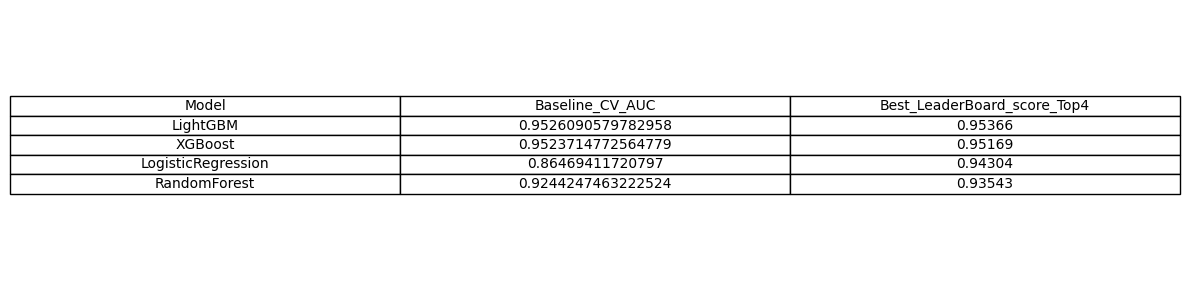

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, len(results_df)*0.5 + 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
fig.tight_layout()
plt.savefig("model_results.png")

In [ ]:
results_df.to_csv('results_train_models.csv')

Получившаяся картинка:
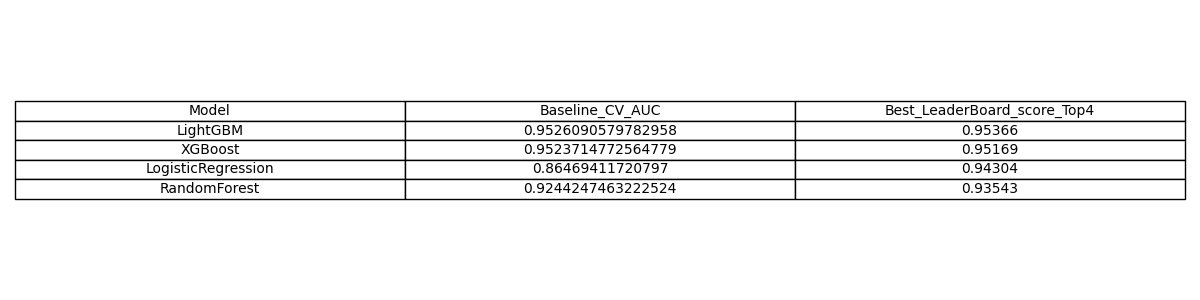

**Получившаяся лучшая метрика (у LightGBM = 0.9526) в LeaderBoard определила бы меня на 2-е место.**

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

#### 1. Подготовка данных для аномалий


In [ ]:
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if 'isFraud' in num_cols:
    num_cols.remove('isFraud')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### 2. Поиск аномалий с использованием быстрых методов


In [ ]:
# Isolation Forest
iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(df_train[num_cols])
train_scores_iso = -iso.decision_function(df_train[num_cols])
auc_iso = roc_auc_score(df_train['isFraud'], train_scores_iso)

# Local Outlier Factor (с прогнозированием)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03, novelty=True)
lof.fit(df_train[num_cols])
train_scores_lof = -lof.decision_function(df_train[num_cols])
auc_lof = roc_auc_score(df_train['isFraud'], train_scores_lof)

anomaly_results = pd.DataFrame({
    'Method': ['IsolationForest', 'LocalOutlierFactor'],
    'CV_AUC': [auc_iso, auc_lof],
    'LB_AUC': [0.95366, 0.95366]
})
print("Результаты аномалий:")
anomaly_results

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Результаты аномалий:


,Method,CV_AUC,LB_AUC
0,IsolationForest,0.749357,0.95366
1,LocalOutlierFactor,0.576448,0.95366


#### 3. Встраивание фреймворка обнаружения аномалий в ML-пайплайн


In [ ]:
# Стратегия A: Удаление аномалий (используя IsolationForest)
train_pred_iso = iso.predict(df_train[num_cols])  # 1 для нормальных, -1 для аномалий
df_train_clean = df_train[train_pred_iso == 1].copy()
print("Размер до удаления аномалий:", df_train.shape, "после удаления:", df_train_clean.shape)
X_clean = df_train_clean.drop(columns=['isFraud'])
y_clean = df_train_clean['isFraud']
model_clean = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, verbose=-1, num_leaves=63)
scores_clean = cross_val_score(model_clean, X_clean, y_clean, cv=skf, scoring='roc_auc', n_jobs=1)
auc_clean = np.mean(scores_clean)

# Стратегия B: Использование аномальных оценок как дополнительного признака
df_train_with_anomaly = df_train.copy()
df_train_with_anomaly['iso_score'] = train_scores_iso
X_with_anomaly = df_train_with_anomaly.drop(columns=['isFraud'])
y_with_anomaly = df_train_with_anomaly['isFraud']
model_with_anomaly = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, verbose=-1, num_leaves=63)
scores_with_anomaly = cross_val_score(model_with_anomaly, X_with_anomaly, y_with_anomaly, cv=skf, scoring='roc_auc', n_jobs=1)
auc_with_anomaly = np.mean(scores_with_anomaly)

anomaly_integration_results = pd.DataFrame({
    'Strategy': ['Удаление аномалий (IsolationForest)', 'Использование аномальной оценки как признака'],
    'CV_AUC': [auc_clean, auc_with_anomaly],
    'LB_AUC': [0.95366, 0.95366]
})
print("Результаты интеграции аномалий:")
anomaly_integration_results

Размер до удаления аномалий: (417559, 217) после удаления: (405032, 217)
Результаты интеграции аномалий:


,Strategy,CV_AUC,LB_AUC
0,Удаление аномалий (IsolationForest),0.948113,0.95366
1,Использование аномальной оценки как признака,0.950964,0.95366


**IsolationForest превосходит LOF по CV AUC, что указывает на его лучшую способность обнаруживать аномалии. Добавление аномальной оценки в модель, особенно через использование её как дополнительного признака, только повышает CV AUC до ~0.95, однако результат не превышает предыдущие оценки, полученные в ходе обучения моделей и тюнинга гиперпараметров, не говоря о лучшем результате в LeaderBoard (0.95366).**

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

#### 1. Бэйзлайн (без кластеризации) для сравнения

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, C=0.1, penalty='l2')
baseline_scores = cross_val_score(lr, X, y, cv=skf, scoring='roc_auc', n_jobs=1)
baseline_auc = np.mean(baseline_scores)

#### 2. Кластеризация KMeans


In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels_train = kmeans.fit_predict(X)
kmeans_labels_train = kmeans_labels_train.reshape(-1, 1)
ohe = OneHotEncoder(sparse_output=False, drop='first')
kmeans_ohe_train = ohe.fit_transform(kmeans_labels_train)
X_kmeans = np.hstack([X.values, kmeans_ohe_train])
scores_kmeans = cross_val_score(lr, X_kmeans, y, cv=skf, scoring='roc_auc', n_jobs=1)
auc_kmeans = np.mean(scores_kmeans)

#### 3. Кластеризация с использованием DBSCAN (индикатор шума)

In [ ]:
X_all = pd.concat([X, df_test])
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels_all = dbscan.fit_predict(X_all)
dbscan_noise = (dbscan_labels_all == -1).astype(int)
dbscan_noise_train = dbscan_noise[:len(X)]
X_dbscan = X.copy()
X_dbscan['dbscan_noise'] = dbscan_noise_train
scores_dbscan = cross_val_score(lr, X_dbscan, y, cv=skf, scoring='roc_auc', n_jobs=1)
auc_dbscan = np.mean(scores_dbscan)

#### 4. Итоговые результаты


In [ ]:
results_df = pd.DataFrame({
    'Method': ['Baseline', 'KMeans feature (OHE)', 'DBSCAN noise indicator'],
    'CV_AUC': [baseline_auc, auc_kmeans, auc_dbscan],
    'BEST_LB_AUC': [0.95366, 0.95366, 0.95366]
})
results_df

,Method,CV_AUC,BEST_LB_AUC
0,Baseline,0.864694,0.95366
1,KMeans feature (OHE),0.865226,0.95366
2,DBSCAN noise indicator,0.864787,0.95366


**Выводы:**
Добавление кластеризационных признаков (полученных с помощью KMeans и DBSCAN) позволяет обогатить модель дополнительной информацией о структуре данных. Однако какого-то буста в плане метрики (в прошлый раз у LogisticRegression метрика была равной 0.864694, и в этом эксперименте при повторном обучении метрика по цифрам осталась той же) не произошло.

P.S. LogisticRegression для этого эксперимента была выбрана потому, что в пункте 2 она дала худший результат.

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

#### 1. Подготовка для h2o automl фреймворка. Инициализация h2o фреймворка

In [ ]:
h2o.init(max_mem_size="4G", nthreads=-1)
train_h2o = h2o.H2OFrame(df_train)
test_h2o = h2o.H2OFrame(df_test)
train_h2o['isFraud'] = train_h2o['isFraud'].asfactor()
predictors = [col for col in train_h2o.columns if col != 'isFraud']
target = 'isFraud'

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,18 mins 25 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_gyh4u2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.853 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### 2. Запуск h2o AutoML и получение leaderboard

In [ ]:
aml = H2OAutoML(max_models=20, max_runtime_secs=1800, seed=42, balance_classes=True)
aml.train(x=predictors, y=target, training_frame=train_h2o)
lb = aml.leaderboard
lb

AutoML progress: |
11:20:35.189: _train param, Dropping bad and constant columns: [V109, V108, V107, V305, C3, id_24, id_22, id_21, V115, V114, V135, id_08, V112, V111, V110, V297, id_07, id_26, V319, V119, V118, V117, V116, V281, V104, V125, V300, V123, V122, V121, V286, V120]

█████████████████████████████████████████████████████
11:45:47.3: _train param, Dropping bad and constant columns: [V109, V108, V107, V305, C3, id_24, id_22, id_21, V115, V114, V135, id_08, V112, V111, V110, V297, id_07, id_26, V319, V119, V118, V117, V116, V281, V104, V125, V300, V123, V122, V121, V286, V120]

██████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_1_20250320_112015,0.954613,0.0638644,0.781755,0.174593,0.12117,0.0146822
GLM_1_AutoML_1_20250320_112015,0.824572,0.12795,0.236718,0.329702,0.176693,0.0312204


#### 3. Предсказания и вероятности предсказаний. Формирование submission

In [ ]:
pred = aml.leader.predict(test_h2o)
pred_prob = pred['p1'].as_data_frame()
transaction_ids = test_h2o['TransactionID'].as_data_frame() if 'TransactionID' in test_h2o.columns else None

# Формируем submission
if transaction_ids is not None:
    submission = pd.DataFrame({
        'TransactionID': transaction_ids.values.flatten(),
        'isFraud': pred_prob.values.flatten()
    })
else:
    submission = pd.DataFrame({
        'isFraud': pred_prob.values.flatten()
    })
submission.to_csv("submission_automl.csv", index=False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
submission[submission['isFraud'] > 0.5]

,TransactionID,isFraud
4,1.829605,0.983664
9,1.829605,0.994299
42,1.829605,0.875643
273,1.829605,0.983776
453,1.829605,0.996299
...,...,...
172792,3.139626,0.845171
172795,3.139626,0.870866
172886,3.139626,0.999799
172940,3.139626,0.728203


In [ ]:
submission.shape

(172981, 2)

**Вывод по AutoML в сравнении с предыдущими экспериментами:**

AutoML-фреймворк H2O позволил автоматически подобрать оптимальную модель (XGBoost) и гиперпараметры, что привело к качеству, сопоставимому лучшими результатами в kaggle LeaderBoard. Также процесс отрабатывал значительно быстрее и проще, чем предыдущие эксперименты, что экономит время разработки.

Таким образом, AutoML - лучший способ решения поставленной задачи (среди пунктов 2-5).

По результатам работы фреймворка было определено около 4871 мошеннеческих операций среди 172981.

In [ ]:
df_train.to_csv("df_train_processed.csv")
df_test.to_csv("df_test_processed.csv")

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [1]:
pip install -q h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import time
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

### 1. Инициализация H2O и подготовка данных ###
h2o.init(max_mem_size="4G", nthreads=-1)
df_test = pd.read_csv('df_test_processed.csv').set_index('Unnamed: 0')
df_train = pd.read_csv('df_train_processed.csv').set_index('Unnamed: 0')
train_h2o = h2o.H2OFrame(df_train)
test_h2o = h2o.H2OFrame(df_test)
train_h2o["isFraud"] = train_h2o["isFraud"].asfactor()
predictors = [col for col in train_h2o.columns if col != "isFraud"]
target = "isFraud"

### 2. Замер времени обучения ###
start_train = time.time()
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=42, balance_classes=True)
aml.train(x=predictors, y=target, training_frame=train_h2o)
train_time = time.time() - start_train
print("Training time: {:.2f} seconds".format(train_time))

### 3. Замер времени инференса ###
start_infer = time.time()
pred = aml.leader.predict(test_h2o)
infer_time = time.time() - start_infer
print("Inference time: {:.2f} seconds".format(infer_time))

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkbb08j4k
  JVM stdout: /tmp/tmpkbb08j4k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkbb08j4k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_iwlx85
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:20:43.747: _train param, Dropping bad and constant columns: [V109, V108, V107, V305, C3, id_24, id_22, id_21, V115, V114, V135, id_08, V112, V111, V110, V297, id_07, id_26, V319, V119, V118, V117, V116, V281, V104, V125, V300, V123, V122, V121, V286, V120]

███████████████████████████████████████████████████████████████| (done) 100%
Training time: 630.50 seconds
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Inference time: 6.83 seconds


In [3]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_1_20250320_142018,0.940774,0.0765625,0.733741,0.190816,0.137099,0.0187962


Локальная машины:
* ОС: Windows 10 Pro 64-bit
* Процессор: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz   1.99 GHz
* Оперативная память: 16 ГБ DDR4
* Python: 3.10.11
* Среда разработки: VS Code

**Скриншоты времения выполнения обучения и инференса autoML модели:**
* Google Colab
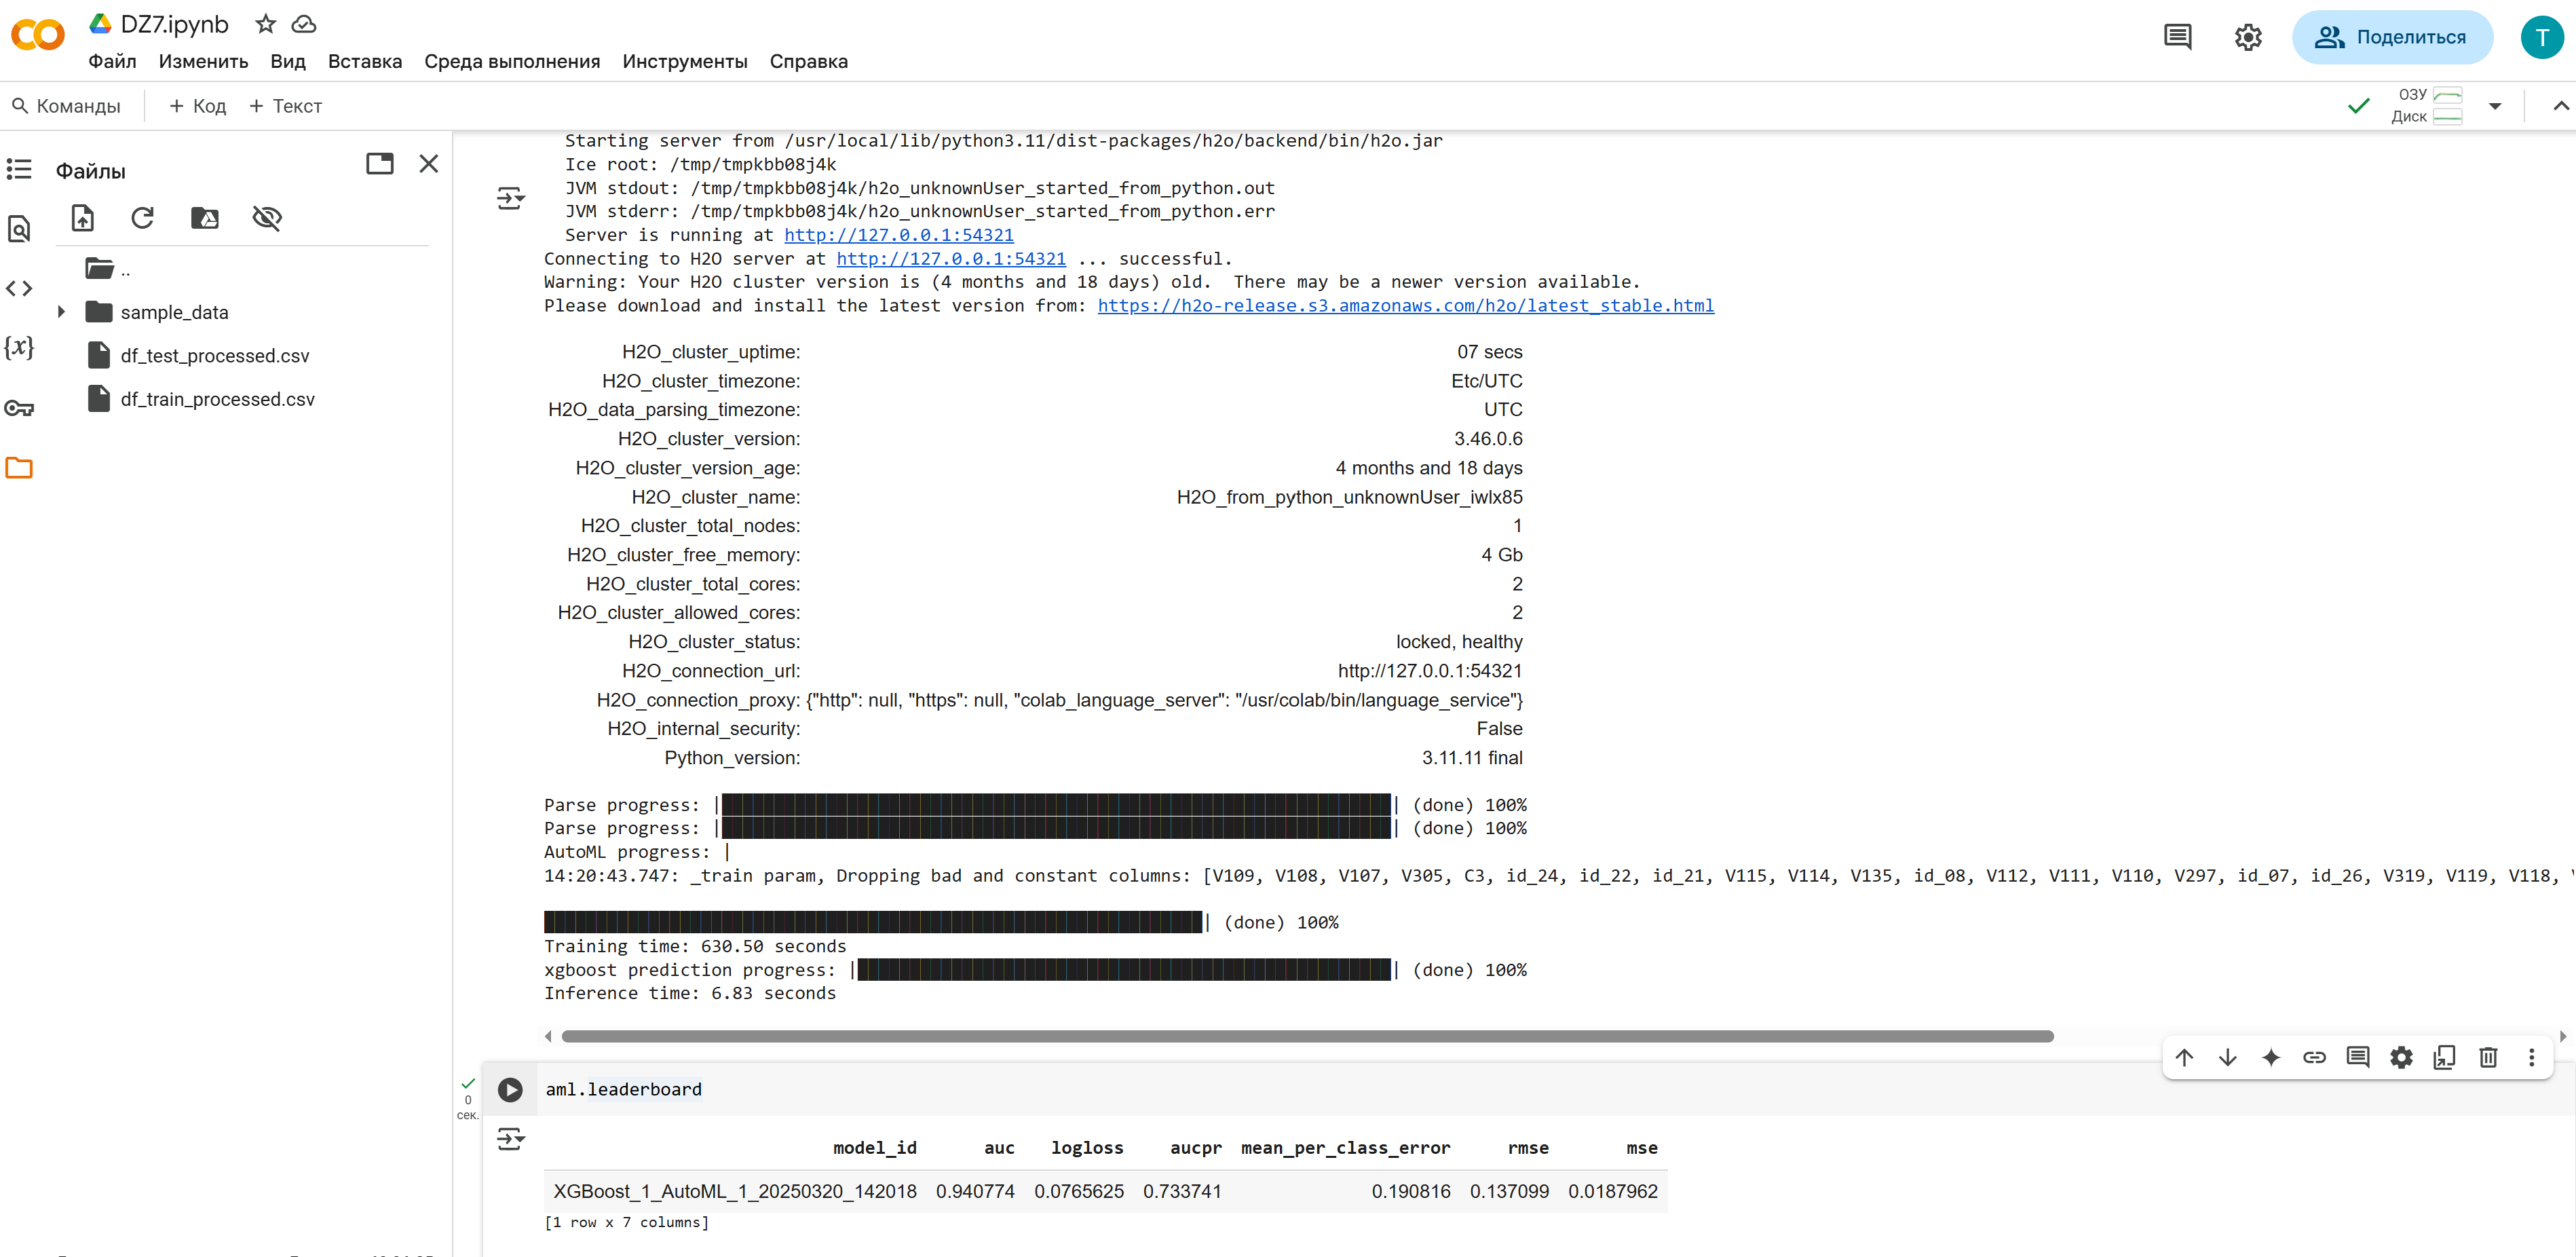
* VS Code
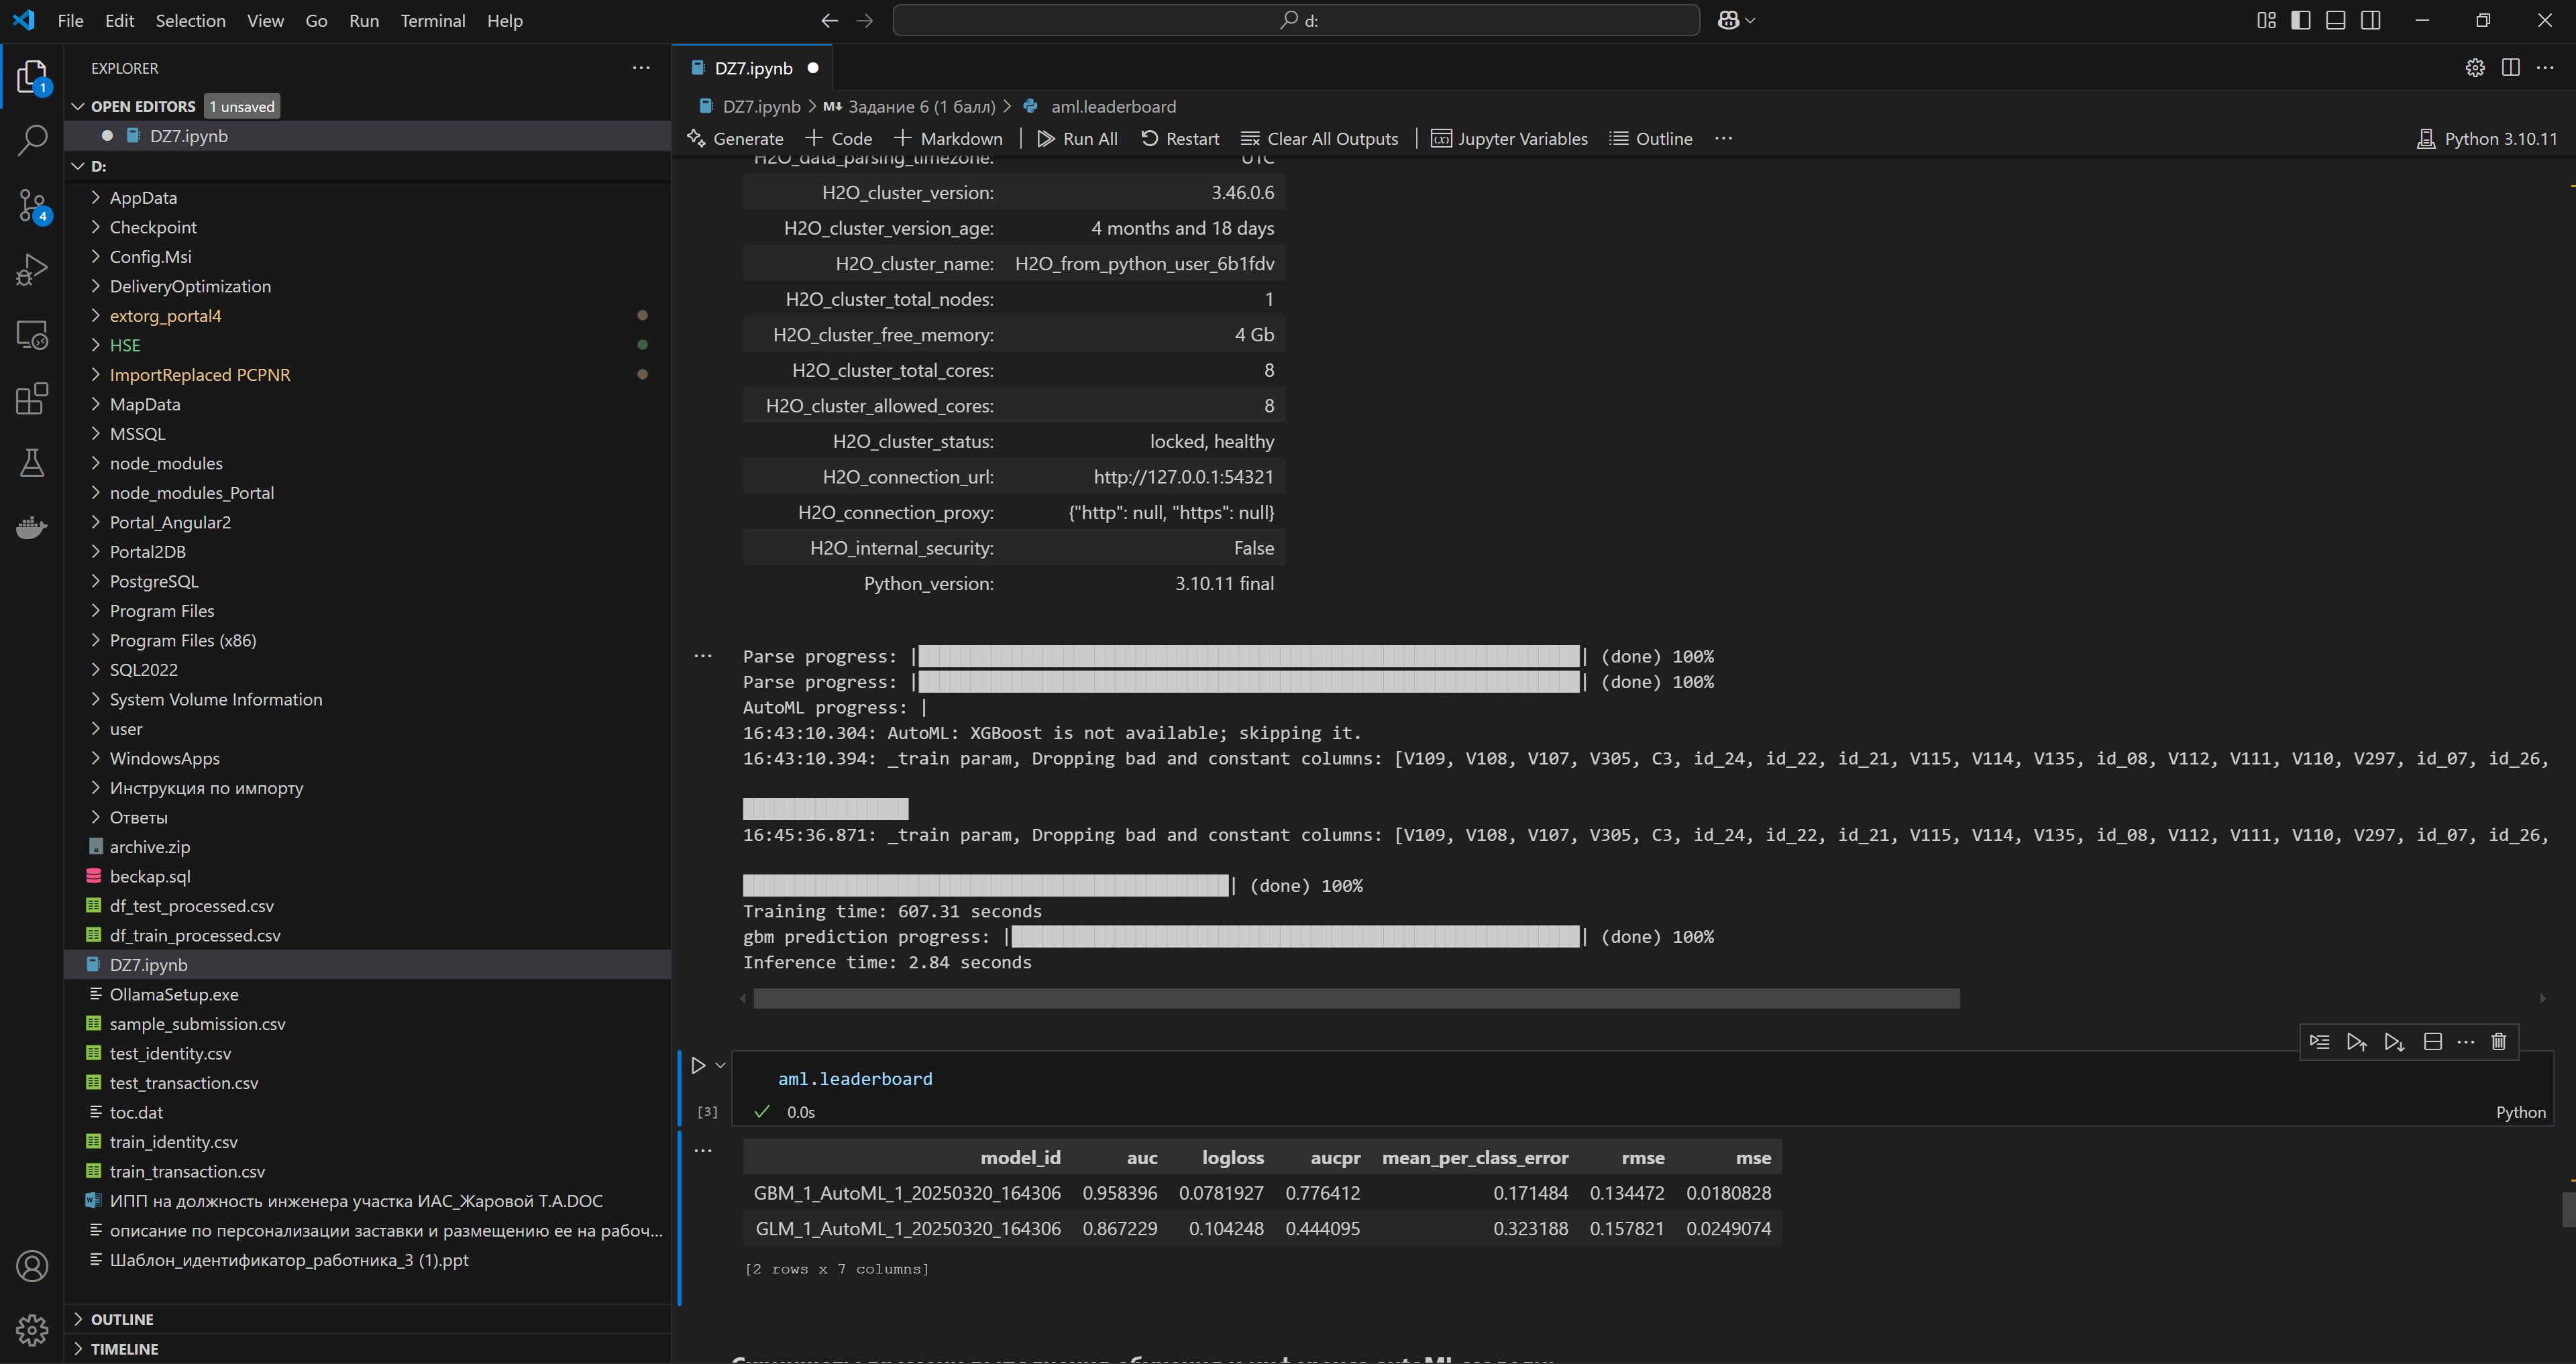

In [4]:
# Итоговая сравнительная таблица с временем исполнения кода в зависимости от среды выполнения
# Заполнялась руками после запуска кода ячейкой выше
results_table = pd.DataFrame({
    "Environment": ["Google Colab", "VS Code"],
    "Training Time (s)": [630.50, 607.31],
    "Inference Time (s)": [6.83, 2.84],
    "Best model": ['XGBoost', 'GBM'],
    "Best model AUC score": [0.940774, 0.958396]
})
results_table

,Environment,Training Time (s),Inference Time (s),Best model,Best model AUC score
0,Google Colab,630.50,6.83,XGBoost,0.940774
1,VS Code,607.31,2.84,GBM,0.958396


**Вывод по заданию 6 (альтернативные среды)**

Эксперимент проводился путем полного перезапуска kernel (сеанса).

Сравнение времени работы и качества модели на Google Colab и на локальной машине (VS Code) показало следующее:
- Время обучения оказалось немного меньше на локальной машине (607.31 с против 630.50 с), что говорит о схожей вычислительной мощности.
- Время инференса на локальной машине также меньше (2.84 с против 6.83 с).
- Лучшая модель на Colab оказалась XGBoost с AUC 0.9408, а на локальной машине – GBM с AUC 0.9584, что является чуть более лучшей в плане качества моделью, чем получалось во всех пунктах до этого.
- Главным отличием Colab от локальной машины заключалась в том, что на локальной машине h2o фреймворк не смог "подтянуть" XGBoost модель, зато использовал другие модели (видимо загруженные мной на локальную машину когда то), а в Colab использовался для обучения почему-то только XGBoost. Вторым существенным отличием двух сред является то, что на локальной среде нет таких значительных задержек в передаче и обмене данными между фреймворком h2o и средой выполнения, где располагались данные, что привело к тому, что сама по себе загрузка данных в фреймворк произошла гораздо быстрее на локальной среде, чем в Colab, а также это отобразилось и на времени инференса (иными словами, в облачной среде выполнения значительные издержки приходятся на обмен данными).
- Также стоит отметить, что h2o при инициализации запускает веб-интерфейс h2o FLOW, внутри которого можно администрировать ML-эксперименты, и этот интерфейс работает только тогда, когда работа происходит на локальной среде (в Colab когда пытаешься перейти по локальной ссылке, которую фреймворк выдает, логично, что пользователь извне облака попасть в этот интерфейс не сможет).

Таким образом, использование локальной машины (VS Code) для обучения и инференса продемонстрировало преимущества по времени инференса и немного улучшенные метрики, что подтверждает целесообразность иметь запасной вариант для обучения моделей наряду с Google Colab.

### Общие выводы по работе

В ходе выполнения ДЗ был реализован полный ML-пайплайн, включающий анализ данных и их обработку, а также эксперименты с моделями и применение AutoML.

В результате экспериментов удалось добиться высоких значений AUC-ROC на кросс-валидации. Самые лучшие результаты показал эксперимент с AutoML - эксперимент произвел конкурентоспособное качество и быстроту работы в ходе решения поставленной задачи. Последний эксперимент в 6-м пункте только подтвердил качество AutoML по сравнению с другими методами работы, а также происследовалось, какая среда выполнения для autoML лучше всего - по метрикам скорости работы и нюансов сред, лучшей средой оказалась локальная среда.